# This document

1. Measure generation success
2. Measure generation time
3. Measuring bootstrapping success / Novelty rate

Generate 100 at a time?

How long does it take to test a circuit compared to simulating it. 

If i have to check each permutation / combination of the inputs, would it be faster to just have a human look at the images?

In [25]:
import torch
import torch.nn as nn
from CircuitSimulation.CircuitSimulator import *
import numpy as np
from diffusers import UNet2DConditionModel
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap
import hashlib

In [8]:
# Set dataset

InitialDataset = torch.tensor([
    [
        [1, 1, 1, 1, 1, 2, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [1, 1, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 2, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
	[
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
		[1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
		[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
		[0, 0, 0, 1, 1, 3, 1, 1, 0, 0],
		[1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
	],
	[
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
		[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 1, 3, 1, 1, 1, 0, 0],
		[0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
		[1, 1, 1, 1, 1, 0, 0, 0, 1, 1],
	],
])

""" I'm considering whether the truth table should be changed to always have inputs defined.
Ultimately, i have for now decided against that, for now.
[
    [0, 0, 0, 0, 2, 2, 2, 2],
    [0, 0, 0, 1, 2, 2, 2, 2],
    [0, 0, 1, 0, 2, 2, 2, 2],
    [0, 0, 1, 1, 2, 2, 2, 2],
    [0, 1, 0, 0, 2, 2, 2, 2],
    [0, 1, 0, 1, 2, 2, 2, 2],
    [0, 1, 1, 0, 2, 2, 2, 2],
    [0, 1, 1, 1, 2, 2, 2, 2],
    [1, 0, 0, 0, 2, 2, 2, 2],
    [1, 0, 0, 1, 2, 2, 2, 2],
    [1, 0, 1, 0, 2, 2, 2, 2],
    [1, 0, 1, 1, 2, 2, 2, 2],
    [1, 1, 0, 0, 2, 2, 2, 2],
    [1, 1, 0, 1, 2, 2, 2, 2],
    [1, 1, 1, 0, 2, 2, 2, 2],
    [1, 1, 1, 1, 2, 2, 2, 2],
]
"""
# InitialLabels = torch.tensor([
# 	[
# 		[0, 0, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[0, 1, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[1, 0, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[1, 1, 2, 2, 1, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 	],
# 	[
# 		[0, 0, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[0, 1, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[1, 0, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[1, 1, 2, 2, 1, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 	],
# 	[
# 		[2, 0, 0, 2, 2, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 0, 1, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 1, 0, 2, 2, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 1, 1, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 	],
# ])


InitialLabels = torch.tensor([
    [
        [1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2 ],
        [1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
    ],
    [
        [1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2 ],
        [1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
    ],
	[
        [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2 ],
        [2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
        [2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
        [2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
    ],
	[
        [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0 ],
        [2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
        [2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
        [2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
    ],
])

def imageToProbabilities(image, numCategories):
    # The categorical scheduler expects each channel to describe the probability of a pixel being of that class
    # Therefore, a RawCircuit, with one channel, needs to be expanded to have numCategories channels

	bs, h, w = image.shape
    
	imageProbabilites = torch.zeros(bs, numCategories, h, w)
	for b in range(bs):
		for i in range(h):
			for j in range(w):
				pixelClass = image[b, i, j]
				imageProbabilites[b, pixelClass, i, j] = 1.0

	return imageProbabilites

# Add channel dimension: [2, 10, 10] → [2, 4, 10, 10]
InitialDataset = imageToProbabilities(InitialDataset, 4)

N = 4 # Duplicate dataset N times, to better make use of batching
InitialDataset = InitialDataset.repeat((N, 1, 1, 1))  
InitialLabels = InitialLabels.repeat((N, 1, 1))       

# Wrap in a TensorDataset
dataset = TensorDataset(InitialDataset, InitialLabels)

# Create DataLoader
loader = DataLoader(dataset, batch_size=64, shuffle=True)

print("dataset generated as 'loader")

dataset generated as 'loader


In [16]:
# Set truthtable embedder

class RowEmbedder(nn.Module):
    def __init__(self, num_categories, vector_length, embedding_dim):
        super().__init__()
        self.shared_embed = nn.Embedding(num_categories, embedding_dim)
        self.position_weights = nn.Parameter(torch.ones(vector_length, embedding_dim))
        self.position_bias = nn.Parameter(torch.zeros(vector_length, embedding_dim))
        
    def forward(self, x):
        # x shape: [batch_size, vector_length]
        shared = self.shared_embed(x)  # [batch_size, vector_length, emb_dim]
        # Apply position-specific scaling and shifting
        return shared * self.position_weights + self.position_bias
    

class TabularTransformer(nn.Module):
    def __init__(self, num_categories, num_features, d_model):
        super().__init__()
        self.d_model = d_model

        self.row_embedding = RowEmbedder(num_categories, num_features, d_model) #num_categories, vector_length, embedding_dim

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model * num_features,
            nhead=8,
            dim_feedforward=2*d_model * num_features,
            batch_first=True,
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=6,
        )
    
    def forward(self, x):
        #batch_size, num_rows, num_cols = x.shape

        rows = self.row_embedding(x) #bs, rows, columns, embedding
        #rows = rows.mean(dim=2)
        rows = rows.flatten(start_dim=2) 
        
    
        transformed = self.transformer(rows)

        return transformed

transformer = TabularTransformer(3, 12, 16)

print("embedder created as transformer")
print(f"Embedded shape: {transformer(InitialLabels)[0].shape}")

embedder created as transformer
Embedded shape: torch.Size([4, 192])


In [17]:
# Set up scheduler

class CategoricalScheduler:
    def __init__(self, TrainSteps = 200, numCategories = 4, betaStart = 0.0001, betaEnd = 0.02):
        self.TrainSteps = TrainSteps
        self.noiseDevice = 'cpu'
        self.numCategories = numCategories

        self.betas = torch.linspace(betaStart, betaEnd, TrainSteps, device=self.noiseDevice)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def addNoise(self, imageBatch, time):
        bs, ch, w, h = imageBatch.shape

        with torch.no_grad():
            alpha_t = self.alpha_cumprod[time].view(-1, 1, 1, 1) # Translates shape (1,) -> (1, 1, 1, 1)

            # the per pixel probability distribution of the categories
            currentProbabilities = imageBatch

            # The chance of each state per pixel when noised            
            updatedProbabilities = currentProbabilities * alpha_t + (1 - alpha_t) / self.numCategories 
            updatedProbabilities = updatedProbabilities.permute(0, 2, 3, 1) # reshape such that it is flattened correctly below
            updatedProbabilities = updatedProbabilities.reshape(bs*w*h, self.numCategories)  
            

            # 1 Sample per value
            categoricalNoise = torch.multinomial(updatedProbabilities, 1, replacement=True)
            categoricalNoise = categoricalNoise.view(bs, w, h) # Shape: [bs, w, h]

            noisedImages = F.one_hot(categoricalNoise, num_classes=self.numCategories)
            noisedImages = noisedImages.permute(0, 3, 1, 2) # [bs, num_classes, w, h]

            return noisedImages

scheduler = CategoricalScheduler()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [40]:
# Create Diffuser

class CategoricalDiffusionModel(nn.Module):
	def __init__(self, imageSize, numCategories, embeddingSize, attentionHeads=8, guidanceProb=0.1):
		super().__init__()
		self.guidance_prob=guidanceProb
		self.model = UNet2DConditionModel(
			sample_size=imageSize, 
			in_channels=numCategories,  # Image channels
			out_channels=numCategories,
			cross_attention_dim=embeddingSize,  # Matches mbedding's token dim 
			attention_head_dim=attentionHeads,     # Smaller head dim for efficiency
            layers_per_block=2,       # how many ResNet layers to use per UNet block
        	block_out_channels=(64, 64, 64), 
			down_block_types=(
				"CrossAttnDownBlock2D",  
				"CrossAttnDownBlock2D",
				"DownBlock2D",
			),
			up_block_types=(
				"UpBlock2D",
				"CrossAttnUpBlock2D",
				"CrossAttnUpBlock2D",
			),
		)
        
	def forward(self, x, t, embedding):
        # Shape of x:
		bs, ch, w, h = x.shape
        
		#Use guidance probability, to help the model learn that 'circuit behvaior' 
		# is a general feature and not specific to a particular embedding.
		if self.training:
			mask = torch.rand_like(embedding, device=x.device) < self.guidance_prob
			embedding[mask] = 0
        
		return self.model(x, t, encoder_hidden_states=embedding).sample

model = CategoricalDiffusionModel(10, 4, 192).to(device)

In [19]:
# Training Function

def trainCatModel(catModel, dataloader, epochs, embeddingModel, losses, PLOTUPDATES = True):
	updateRate = 10 # For plotting purposes

	loss_fn = nn.CrossEntropyLoss() #nn.MSELoss(reduction='sum')

	if PLOTUPDATES:
		fig, ax = plt.subplots(figsize=(8, 5))
	
	opt = torch.optim.Adam(model.parameters(), lr=1e-4) 

	for epoch in range(epochs):
		
		for batch, labels in dataloader:

			timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

			noisyImgs = scheduler.addNoise(batch, timesteps)

			embeddings = embeddingModel(labels)

			pred = model(noisyImgs.to(device).float(), timesteps.to(device), embeddings.to(device))
			pred = F.softmax(pred, dim=1) 

			loss = loss_fn(pred, batch.to(device).argmax(axis=1)) 

			opt.zero_grad()
			loss.backward()
			opt.step()
			losses.append(loss.item())

		if PLOTUPDATES:
			if epoch % updateRate == 0:
				clear_output(wait=True)  
				ax.clear()
				plt.plot(losses)
				plt.xlabel('Batch')
				display(fig)
	
	if PLOTUPDATES:
		clear_output(wait=True)  
		ax.clear()
	plt.plot(losses)
	plt.xlabel('Batch')
	if PLOTUPDATES:
		display(fig)

	return catModel, losses

In [ ]:
# Create hashes of data to compare synthetic data with real data

# Function to get the hash of a tensor
def get_tensor_hash(tensor):
    # Flatten the tensor and convert to tuple (hashable)
    tensor_tuple = tuple(tensor.flatten().tolist())
    
    # Compute the hash using hashlib (SHA-256)
    hash_object = hashlib.sha256(str(tensor_tuple).encode())
    return hash_object.hexdigest()

dataset_hashes = [get_tensor_hash(tensor) for tensor in InitialDataset]
labels_hashes = [get_tensor_hash(tensor) for tensor in InitialLabels]

# This would be more efficient sorted

print("Dataset Hashes:", dataset_hashes[0])
print("Labels Hashes:", labels_hashes[0])

Dataset Hashes: d01dc7808adbef603c4f814bf59cdf9f3c51fc50fe60b155a18305e396263949
Labels Hashes: 91f304c599ecebca9504997129d996279c6c51315833fbf58dc318326dd55569


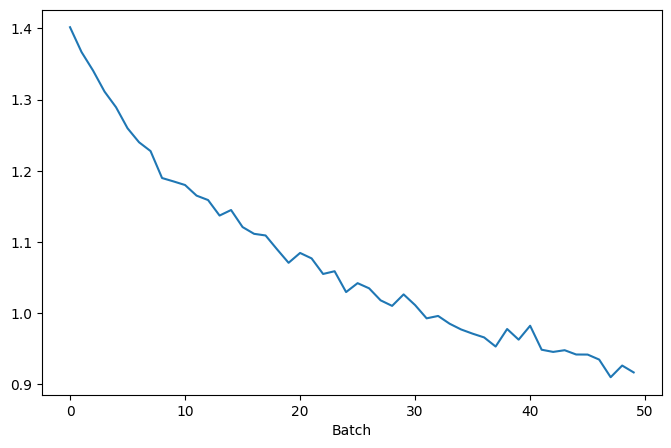

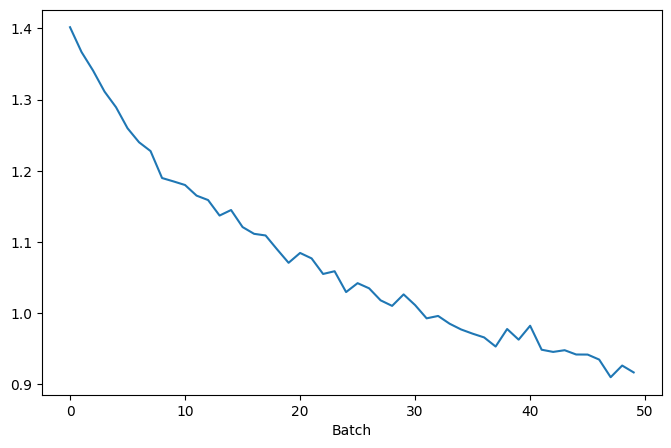

In [41]:
# FOR TEST, Train first
loss = []
model, loss = trainCatModel(model, loader, 50, transformer, loss)

In [81]:
testX = torch.randint_like(InitialDataset[0:1], high=1, low=0, device=device)  # [1, 4, 10, 10]
#testY = torch.randint_like(InitialLabels[0:1], high=2, low=0, device='cpu')  
testY = InitialLabels[0:1]
testY = transformer(testY).to(device)
#testY = transformer(InitialLabels[0:1]).to(device)


inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps // 64, device='cpu').long()

for t in inferenceSteps:
    with torch.no_grad():
        residual_cond = model(testX.to(device).float(), t, testY.float()) 
        
        residual = F.softmax(residual_cond, dim=1)
    testX = scheduler.addNoise(residual.to('cpu'), t - 1).float()
testX = F.softmax(model(testX.to(device), 0, testY), dim=1)

outX = torch.argmax(testX, dim=1, keepdim=True).cpu().numpy().squeeze()
outX

array([[1, 1, 1, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [82]:
# dataset_hashes = [get_tensor_hash(tensor) for tensor in InitialDataset]
# labels_hashes = [get_tensor_hash(tensor) for tensor in InitialLabels]

print(any(datahash == get_tensor_hash(outX) for datahash in dataset_hashes))

inpSockets = [
    (Socket("inp0", True), (0, 0)), 
    (Socket("inp1", True), (0, 3)), 
    (Socket("inp2", True), (0, 6)), 
    (Socket("inp3", True), (0, 9)), 
]

outSockets = [  
	(Socket("out0", False), (9, 0)), 
    (Socket("out1", False), (9, 3)), 
    (Socket("out2", False), (9, 6)), 
    (Socket("out3", False), (9, 9)),
]

socketMap, WireSets = GetSocketMap(outX, inpSockets + outSockets)
connectionMap = GetConnectionMap(socketMap)
print(WireSets)	
print(socketMap)
print(connectionMap)


False
[[1 1 1 1 0 0 0 0 2 0]
 [0 0 0 1 0 0 0 0 2 0]
 [0 0 0 1 0 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
{inp0: {1}, inp1: {1}, inp2: set(), inp3: set(), out0: {2}, out1: set(), out2: set(), out3: set()}
{1: [inp0, inp1], 2: [out0]}


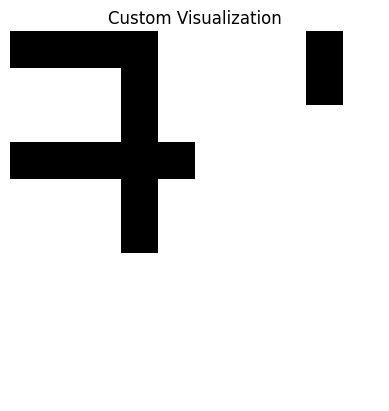

In [83]:
cmap = ListedColormap(['white', 'black', 'red', 'blue'])

plt.imshow(outX, cmap=cmap, vmin=0, vmax=3)
plt.title("Custom Visualization")
plt.axis('off')
plt.show()

In [84]:
bool(socketMap['inp2'])

False

In [85]:
# To prune

# Get relevant inputs
connectedInputs = []
connectedOutputs = []
for socket in socketMap.keys():
    prefix, compid, comptype = socket.name
    
    if prefix == "inp" and bool(socketMap[socket]):
        connectedInputs.append(int(compid))
    elif prefix == "out" and bool(socketMap[socket]):
        connectedOutputs.append(int(compid))
        
print(connectedInputs)
print(connectedOutputs)
        
# Prune useless connections

prunedConnections = []
for connection in connectionMap:
    #if connec
    print(connection)

    relevantConnection = any(
        component.isSource for component in connectionMap[connection]
	) and any(
        not component.isSource for component in connectionMap[connection]
	)
    
    if not relevantConnection:
        prunedConnections.append(connection)
        
print(prunedConnections)

#connectionMap

for connection in prunedConnections:
	del connectionMap[connection]
    
	for i in range(outX.shape[0]):
		for j in range(outX.shape[1]):
			if WireSets[i][j] == connection:
				outX[i][j] = 0
                        
outX

[0, 1]
[0]
1
2
[1, 2]


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
# Issues:

# The above is just empty.
# Simulation should be fast
# But socketmap is not updated to remove connections.
# Pruning should be done before finding inputs and outputs.
# Then remove pruned connections from all sockets
# then find inputs and outputs.
# Then if inputs are empty, stop.

Now, create 100 samples, simulate and measure them

But before that, I don't have code to measure even 1

So,
1. Make one sample circuit
2. Prune it
3. Simulate it
4. Generate Truthtable for it.
5. Compare novelty 

For novelty, i would need to check if truthtable is already present in dataset, and if so, if circuit is novel or not.

Perhaps, when model has trained a lot, it would suffice to just directly check if the circuit is equivalent to any of the existing ones.



In [ ]:
# Speed up the input permutation by pruning outputs first


# loss = []
# catModel, loss = trainCatModel(model, loader, 10, transformer, loss)